In [2]:
import pickle, re, keras, joblib
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import rankdata
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


2025-03-13 10:51:04.214356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def filterTitle(value):
    value = re.sub(r"_\w+", "", value) 
    value = re.sub(r"RNNSimple", "SRNN", value) 
    return value

In [4]:
def kernel_mse_loss(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred) 

keras.utils.get_custom_objects()["kernel_mse_loss"] = kernel_mse_loss

In [5]:
with open('./Results/Results_2.pkl', 'rb') as f:    
    results = pickle.load(f)

dataset = joblib.load('./Figures/data_UMAPDA.pkl') 

results.keys()

dict_keys([('Argone', 0.0), ('Argone', 0.001), ('Argone', 0.002), ('Argone', 0.005), ('Argone', 0.007), ('Argone', 0.01), ('Argone', 0.02), ('Beijing', 0.0), ('Beijing', 0.001), ('Beijing', 0.002), ('Beijing', 0.005), ('Beijing', 0.007), ('Beijing', 0.01), ('Beijing', 0.02), ('Chengdu', 0.0), ('Chengdu', 0.001), ('Chengdu', 0.002), ('Chengdu', 0.005), ('Chengdu', 0.007), ('Chengdu', 0.01), ('Chengdu', 0.02)])

In [6]:
Xc = dataset['Xc']
Yc = dataset['Yc']
label_dat = dataset['label_dat'].ravel()
names_ = dataset['names_']
ths = dataset['ths']
ind_total_aug = dataset['ind_total_aug']

In [7]:
names_

['Argone', 'Beijing', 'Chengdu']

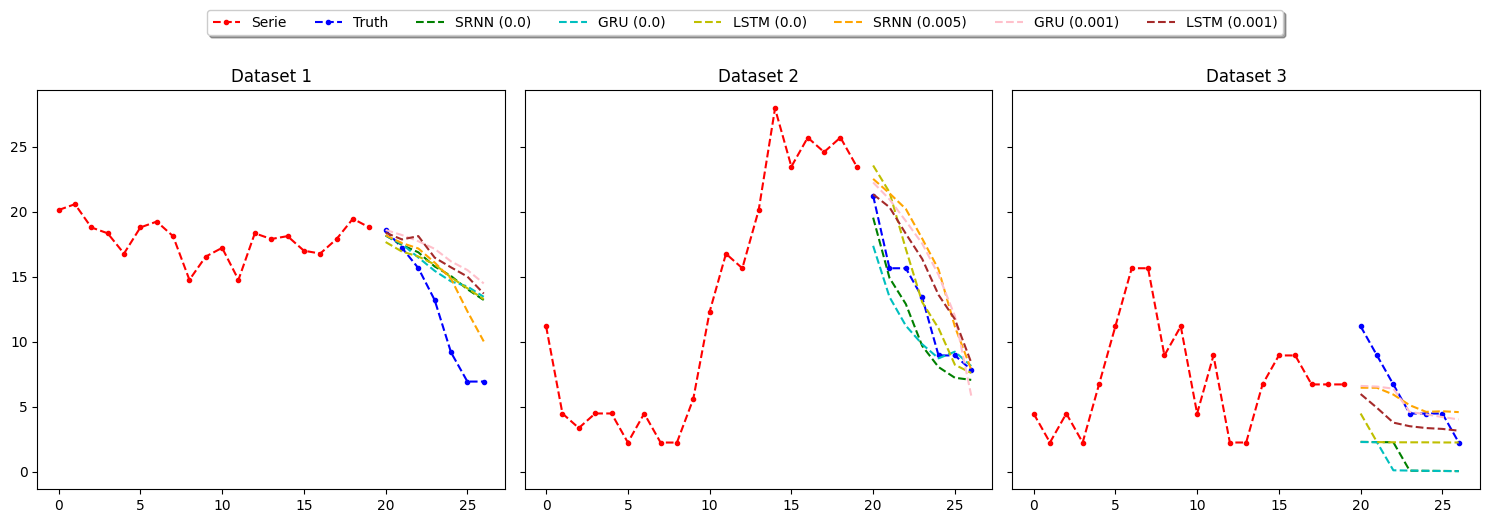

In [8]:
datasets = ['Argone', 'Beijing', 'Chengdu']
models = ['RNNSimple_Model', 'GRU_Model', 'LSTM_Model']

models_th = {"1": [("RNNSimple_Model", 0.005), ("GRU_Model", 0.001), ("LSTM_Model", 0.001)], 
             "2": [("RNNSimple_Model", 0.02), ("GRU_Model", 0.007), ("LSTM_Model", 0.02)],
             "3": [("RNNSimple_Model", 0.02), ("GRU_Model", 0.02), ("LSTM_Model", 0.007)]} 


thresholds = [0.0, 0.001]
train_size = 0.8
val_size = 0.2
random_state = 123

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # Compartir eje Y para consistencia
lines = []  # Lista para almacenar las líneas de los gráficos
labels = []  # Lista para almacenar las etiquetas

for idx, datai in enumerate(range(1, 4)):  # 1: Argone, 2: Beijing, 3: Chengdu
    ax = axes[idx]  # Seleccionar el eje correspondiente
    
    # Real --------------------------------------------------------
    X_ = Xc[label_dat == datai]
    Y_ = Yc[label_dat == datai]
    nsamples = X_.shape[0]
    Xtest = X_[int(nsamples * train_size):]
    Ytest = Y_[int(nsamples * train_size):]
    
    i = 100
    input_ = Xtest[i, :] * dataset['max_']
    output_ = Ytest[i, :]
    time = np.arange(0, input_.shape[0] + output_.shape[0], 1)

    l1, = ax.plot(time[0:input_.shape[0]], input_, '--.r', label='Serie')
    l2, = ax.plot(time[input_.shape[0]:], output_, '--.b', label='Truth')

    # Guardamos las líneas y etiquetas para la leyenda
    if idx == 0:
        lines.extend([l1, l2])
        labels.extend(['Serie', 'Truth'])

    # Prediction without DA ---------------------------------------
    for model, color in zip(models, ['g', 'c', 'y']):
        value = results[(datasets[datai - 1], 0.0)][model]['Ypred'][i, :]
        l, = ax.plot(time[input_.shape[0]:], value, '--', c=color, label=f"{filterTitle(model)} (0.0)")
        
        if idx == 0:
            lines.append(l)
            labels.append(f"{filterTitle(model)} (0.0)")

    # Prediction with DA ------------------------------------------
    neuralNetworks_th = models_th[str(datai)]
    for (mo, th_mo), color in zip(neuralNetworks_th, ["orange", "pink", "brown"]):
        value = results[(datasets[datai - 1], th_mo)][mo]['Ypred'][i, :]
        l, = ax.plot(time[input_.shape[0]:], value, '--', c=color, label=f"{filterTitle(mo)} ({th_mo})")

        if idx == 0:
            lines.append(l)
            labels.append(f"{filterTitle(mo)} ({th_mo})")

    ax.set_title(f"Dataset {datai}")  # Título de cada subgráfico

# Crear la leyenda global fuera del gráfico
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True, ncol=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar layout para no sobreponer la leyenda
plt.show()


(10863, 7)


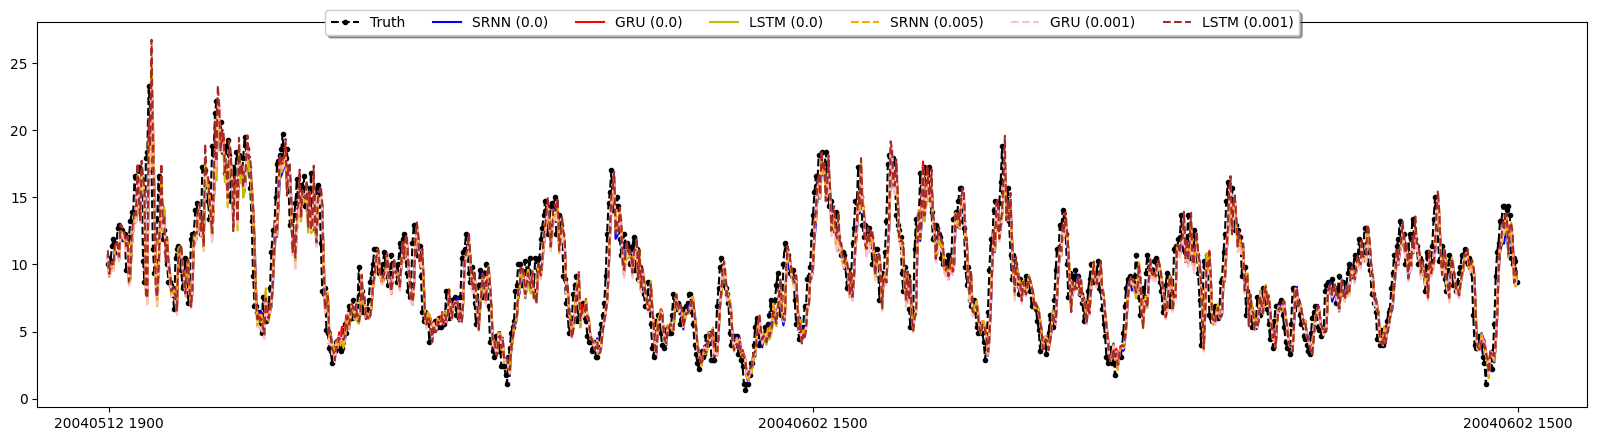

(10395, 7)


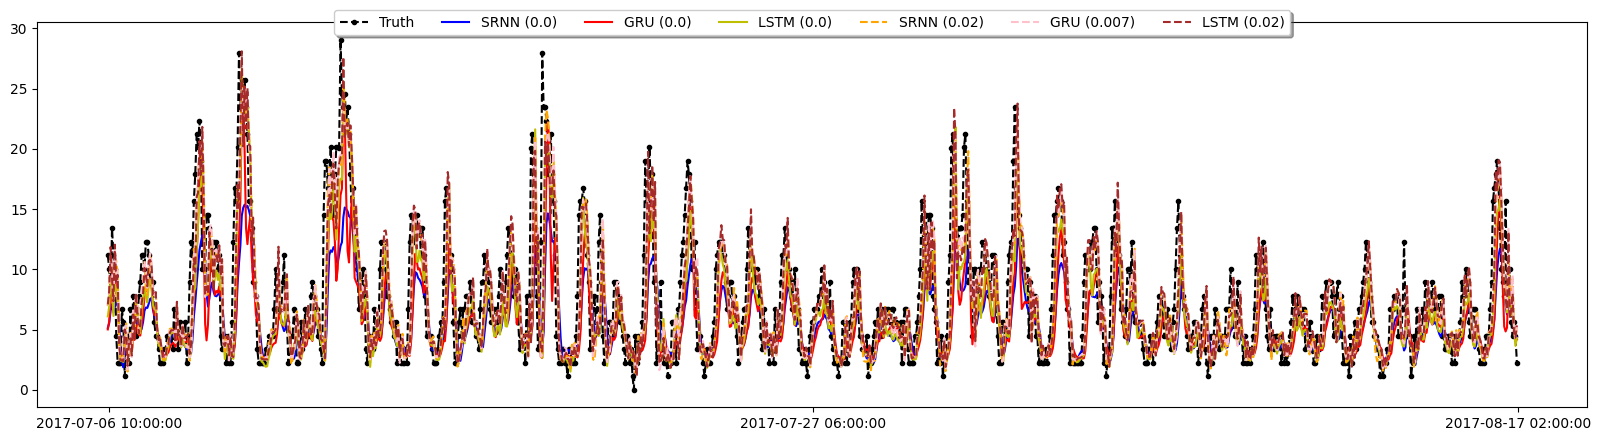

(11150, 7)


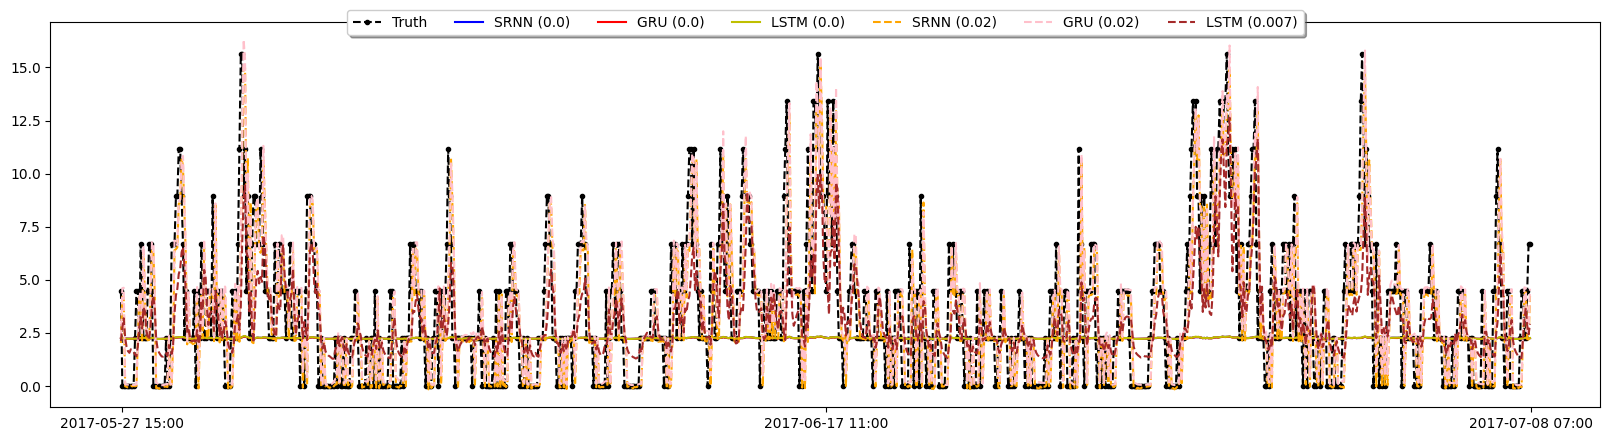

In [9]:
horizon_ = 1
for datai in range(1, 4):

    # Real --------------------------------------------------------
    X_ = Xc[label_dat == datai]
    Y_ = Yc[label_dat == datai]
    nsamples = X_.shape[0]
    Xtest = X_[int(nsamples * train_size):]
    Ytest = Y_[int(nsamples * train_size):]

    input_ = Xtest[:, horizon_] * dataset['max_']
    output_ = Ytest[:, horizon_]
    time = np.arange(0, input_.shape[0] + output_.shape[0], 1)

    print(Ytest.shape)

    plt.figure(figsize=(20, 5))
    # Truth -------------------------------------------------------
    value = Ytest[:, horizon_][0:1000]
    plt.plot(value, '--.k', label=f"Truth")

    # Prediction without DA ---------------------------------------
    for model, color in zip(models, ['b', 'r', 'y']):
        value = results[(datasets[datai - 1], 0.0)][model]['Ypred'][:, horizon_][0:1000]
        plt.plot(value, c=color, label=f"{filterTitle(model)} (0.0)")
    
    # Prediction with DA ------------------------------------------
    neuralNetworks_th = models_th[str(datai)]
    for (mo, th_mo), color in zip(neuralNetworks_th, ["orange", "pink", "brown"]):
        value = results[(datasets[datai - 1], th_mo)][mo]['Ypred'][:, horizon_][0:1000]
        plt.plot(value, '--', c=color, label=f"{filterTitle(mo)} ({th_mo})")

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fancybox=True, shadow=True, ncol=8)
    if datai == 1:
        plt.xticks([1,500, 1000], ['20040512 1900', '20040602 1500', '20040602 1500'])
    if datai == 2:
        plt.xticks([1,500, 1000], ['2017-07-06 10:00:00', '2017-07-27 06:00:00', '2017-08-17 02:00:00'])
    if datai == 3:
        plt.xticks([1,500, 1000], ['2017-05-27 15:00', '2017-06-17 11:00', '2017-07-08 07:00'])
        
    plt.show()
    

    
    

(10863, 7)
(10395, 7)
(11150, 7)


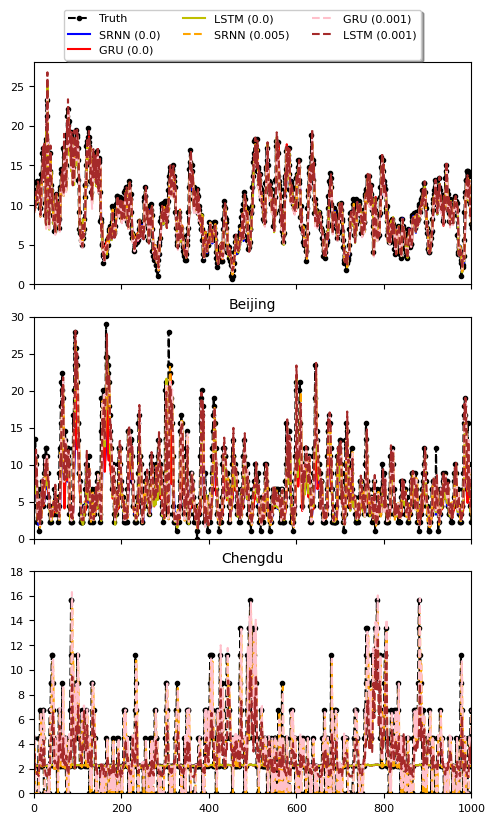

In [10]:
horizon_ = 1
fig, axes = plt.subplots(3, 1, figsize=(5, 8), sharex=True)  # Tamaño más compacto

# Definir los límites de Y personalizados para cada dataset
ylim_values = [(0, 28), (0, 30), (0, 18)]  # Ajuste según necesidad

lines = []  # Para almacenar líneas de la leyenda
labels = []  # Para almacenar etiquetas de la leyenda

for idx, datai in enumerate(range(1, 4)):
    ax = axes[idx]  # Seleccionar el subplot correspondiente
    
    # Real --------------------------------------------------------
    X_ = Xc[label_dat == datai]
    Y_ = Yc[label_dat == datai]
    nsamples = X_.shape[0]
    Xtest = X_[int(nsamples * train_size):]
    Ytest = Y_[int(nsamples * train_size):]

    input_ = Xtest[:, horizon_] * dataset['max_']
    output_ = Ytest[:, horizon_]
    time = np.arange(0, input_.shape[0] + output_.shape[0], 1)

    print(Ytest.shape)

    # Truth -------------------------------------------------------
    value = Ytest[:, horizon_]
    l1, = ax.plot(value, '--.k', label="Truth")  # Verdad en negro
    
    if idx == 0:
        lines.append(l1)
        labels.append("Truth")

    # Prediction without DA ---------------------------------------
    for model, color in zip(models, ['b', 'r', 'y']):
        value = results[(datasets[datai - 1], 0.0)][model]['Ypred'][:, horizon_]
        l, = ax.plot(value, c=color, label=f"{filterTitle(model)} (0.0)")
        
        if idx == 0:
            lines.append(l)
            labels.append(f"{filterTitle(model)} (0.0)")

    # Prediction with DA ------------------------------------------
    neuralNetworks_th = models_th[str(datai)]
    for (mo, th_mo), color in zip(neuralNetworks_th, ["orange", "pink", "brown"]):
        value = results[(datasets[datai - 1], th_mo)][mo]['Ypred'][:, horizon_]
        l, = ax.plot(value, '--', c=color, label=f"{filterTitle(mo)} ({th_mo})")
        
        if idx == 0:
            lines.append(l)
            labels.append(f"{filterTitle(mo)} ({th_mo})")

    ax.set_title(f"{datasets[datai-1]}", fontsize=10)  # Reducimos el tamaño del título
    ax.set_xlim(0, 1000)
    ax.set_ylim(ylim_values[idx])  # Aplicar límites de Y específicos
    ax.tick_params(axis='both', labelsize=8)  # Reducimos el tamaño de las etiquetas de los ejes

# Agregar una sola leyenda en la parte superior con tamaño reducido
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), fancybox=True, shadow=True, ncol=3, fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.98], pad=0.5)  # Ajustamos el diseño para reducir espacios
plt.show()


In [11]:
"""
Argonne
    0: 20040512 1900
    500: 20040602 1500
    1000: 20040623 1100
Beijing
    0: 2017-07-06 10:00:00
    500: 2017-07-27 06:00:00
    1000: 2017-08-17 02:00:00
Chengdu
    0: 2017-05-27 15:00
    500: 2017-06-17 11:00
    1000: 2017-07-08 07:00  
"""

'\nArgonne\n    0: 20040512 1900\n    500: 20040602 1500\n    1000: 20040623 1100\nBeijing\n    0: 2017-07-06 10:00:00\n    500: 2017-07-27 06:00:00\n    1000: 2017-08-17 02:00:00\nChengdu\n    0: 2017-05-27 15:00\n    500: 2017-06-17 11:00\n    1000: 2017-07-08 07:00  \n'

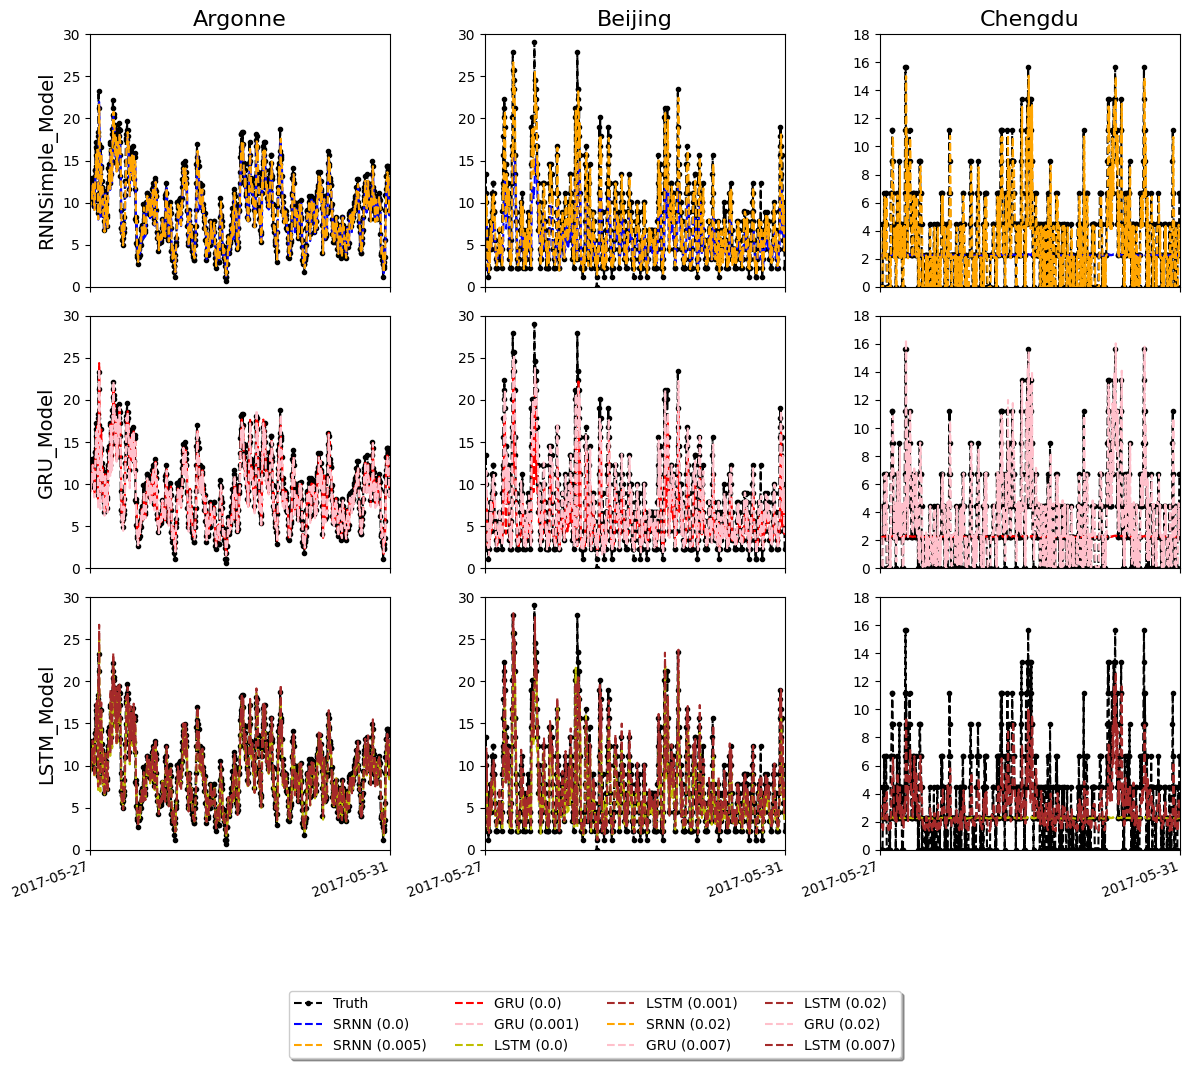

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que tienes estos arrays/diccionarios globales:
# Xc, Yc, label_dat, train_size, dataset, results, models_th, filterTitle, etc.

###############################################################################
# 1) Definir nombres y mapeos directos de cada dataset
###############################################################################
dataset_names = ["Argone", "Beijing", "Chengdu"]

# Mapeo: nombre del dataset -> valor de label_dat (1, 2 o 3)
ds_map = {"Argone": 1, "Beijing": 2, "Chengdu": 3}

# Fechas para el eje X
xticks_info = {
    "Argone":  ([0, 1000], ["2004-05-12", "2004-05-16"]),
    "Beijing":  ([0, 1000], ["2017-07-06", "2017-07-10"]),
    "Chengdu":  ([0, 1000], ["2017-05-27", "2017-05-31"]),
}

# Límites en el eje Y
y_limits_dict = {
    "Argone": (0, 30),
    "Beijing": (0, 30),
    "Chengdu": (0, 18),
}

###############################################################################
# 2) Definir los modelos, colores y orden de las filas
###############################################################################
models_order = ["RNNSimple_Model", "GRU_Model", "LSTM_Model"]  # 3 filas
colors_no_DA = ['b', 'r', 'y']        # Para las predicciones sin DA
colors_DA    = ["orange", "pink", "brown"]  # Para las predicciones con DA

###############################################################################
# 3) Crear la figura de 3 filas x 3 columnas
###############################################################################
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True)

# Preparar variables para la leyenda única
lines = []
labels = []
legend_set = set()  # Para evitar duplicados en la leyenda

###############################################################################
# 4) Bucle principal para llenar la cuadrícula
###############################################################################
horizon_ = 1

for col_idx, ds_name in enumerate(dataset_names):      # 3 columnas
    ds_label = ds_map[ds_name]                         # 1=Argonne, 2=Beijing, 3=Chengdu

    # Filtrar datos según el dataset
    X_ = Xc[label_dat == ds_label]
    Y_ = Yc[label_dat == ds_label]
    nsamples = X_.shape[0]

    # Separar datos de test
    Xtest = X_[int(nsamples * train_size):]
    Ytest = Y_[int(nsamples * train_size):]

    # (Opcional) time array, si lo usas para algo más
    # time = np.arange(0, Xtest.shape[0] + Ytest.shape[0], 1)

    for row_idx, model_name in enumerate(models_order):  # 3 filas
        ax = axes[row_idx, col_idx]

        ###############################################################################
        # 4.1) Graficar la serie "True" (Ytest)
        ###############################################################################
        y_true = Ytest[:, horizon_][0:1000]
        line_true, = ax.plot(y_true, '--.k', label="Truth")

        # Agregar a la leyenda solo si no está ya
        if "Truth" not in legend_set:
            lines.append(line_true)
            labels.append("Truth")
            legend_set.add("Truth")

        ###############################################################################
        # 4.2) Predicción sin DA (umbral = 0.0)
        ###############################################################################
        y_pred_no_DA = results[(ds_name, 0.0)][model_name]['Ypred'][:, horizon_][0:1000]
        line_no_DA, = ax.plot(y_pred_no_DA, '--', c=colors_no_DA[row_idx],
                              label=f"{filterTitle(model_name)} (0.0)")

        # Agregar a la leyenda solo si no está ya
        legend_label_no_DA = f"{filterTitle(model_name)} (0.0)"
        if legend_label_no_DA not in legend_set:
            lines.append(line_no_DA)
            labels.append(legend_label_no_DA)
            legend_set.add(legend_label_no_DA)

        ###############################################################################
        # 4.3) Predicción con DA (mejores umbrales)
        ###############################################################################
        # 'models_th' tiene la info de los umbrales para cada dataset en 'str(ds_label)'
        # Por ejemplo: models_th["1"] = [("RNNSimple_Model", 0.005), ("GRU_Model", 0.001), ("LSTM_Model", 0.001)]
        # Filtramos solo el (mo, th_mo) que coincida con 'model_name'
        neuralNetworks_th = models_th[str(ds_label)]
        for (mo, th_mo), color_ in zip(neuralNetworks_th, colors_DA):
            if mo == model_name:
                y_pred_DA = results[(ds_name, th_mo)][mo]['Ypred'][:, horizon_][0:1000]
                line_DA, = ax.plot(y_pred_DA, '--', c=color_, label=f"{filterTitle(mo)} ({th_mo})")

                # Agregar a la leyenda solo si no está ya
                legend_label_DA = f"{filterTitle(mo)} ({th_mo})"
                if legend_label_DA not in legend_set:
                    lines.append(line_DA)
                    labels.append(legend_label_DA)
                    legend_set.add(legend_label_DA)

        ###############################################################################
        # 4.4) Configurar títulos y ejes
        ###############################################################################
        # Título para la primera fila
        if row_idx == 0:
            if ds_name == 'Argone':
                ax.set_title('Argonne', fontsize=16)
            else: 
                ax.set_title(ds_name, fontsize=16)

        # Etiqueta en el eje Y con el nombre del modelo
        if col_idx == 0:
            ax.set_ylabel(model_name, fontsize=14, rotation=90)

        # Límite en X (0 a 1000)
        ax.set_xlim(0, 1000)

        # Límite en Y según el dataset
        y_min, y_max = y_limits_dict[ds_name]
        ax.set_ylim(y_min, y_max)

        # Ajustar el tamaño de los valores en el eje Y
        ax.tick_params(axis='y', labelsize=10)

        # Asignar los xticks y etiquetas correctas según el dataset
        xticks_positions, xticks_labels = xticks_info[ds_name]  # ([0, 1000], ["2004-05-12", "2004-06-23"]) ...
        ax.set_xticks(xticks_positions)
        ax.set_xticklabels(xticks_labels, fontsize=10, rotation=20, ha="right")

###############################################################################
# 5) Leyenda única en la parte inferior
###############################################################################
fig.legend(lines, labels, loc='lower center',
           bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True,
           ncol=4, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.92])  # Ajustamos el diseño para dejar espacio en la parte inferior

# Guardar la imagen en formato PDF con alta calidad
filename_ = "./Results/Recontructions.pdf"
plt.savefig(filename_, dpi=300, bbox_inches='tight')
plt.show()


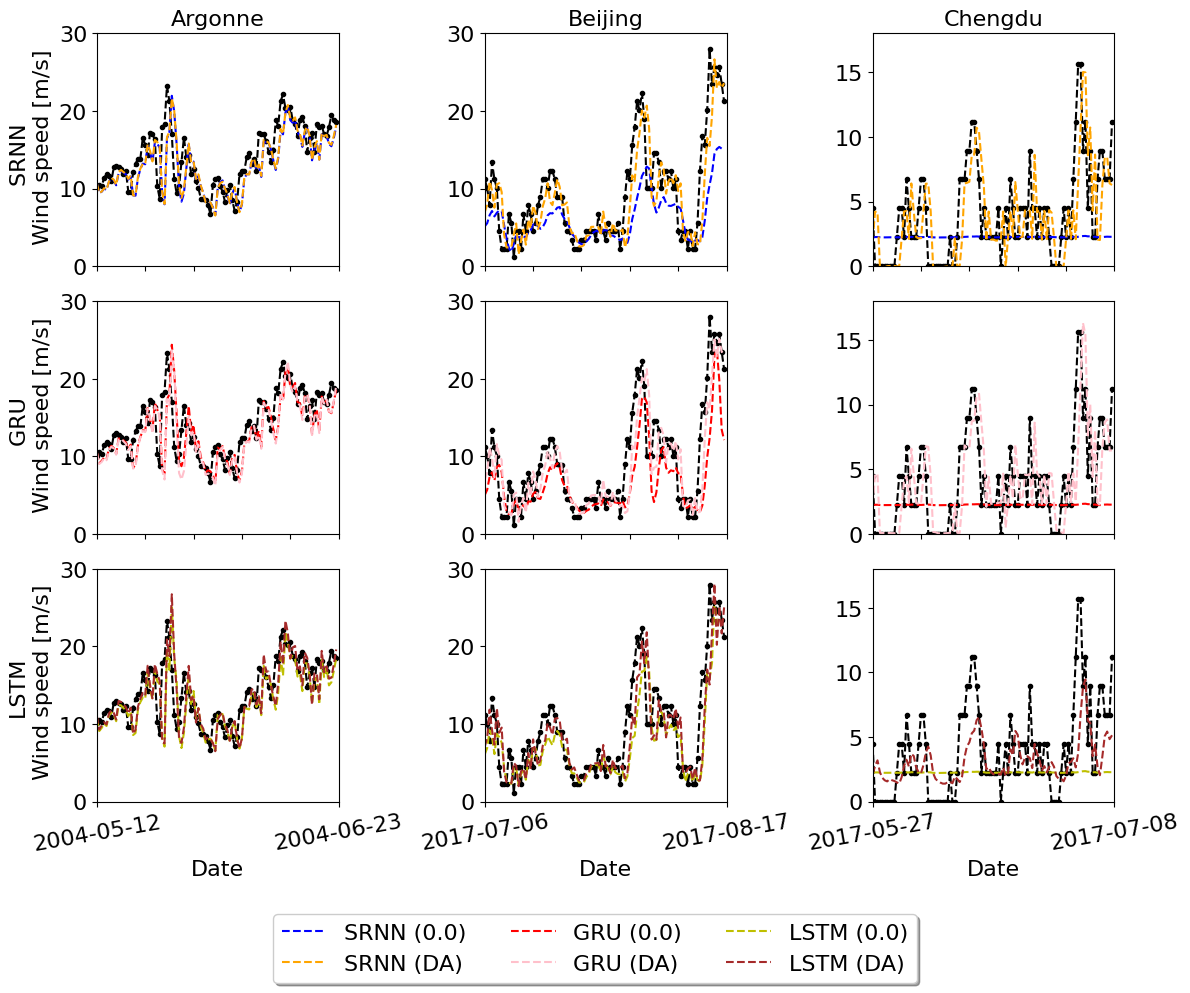

In [19]:
import matplotlib.pyplot as plt
import numpy as np

###############################################################################
# 1) CONFIGURACIÓN BÁSICA
###############################################################################
horizon_ = 1
fig, axes = plt.subplots(3, 3, figsize=(12, 10))  # 3 filas (modelos) x 3 columnas (datasets)

# Diccionario con los xticks específicos para cada dataset
xticks_dict = {
    1: {0: "2004-05-12", 100: "2004-06-23"},  # Argonne
    2: {0: "2017-07-06", 100: "2017-08-17"},  # Beijing
    3: {0: "2017-05-27", 100: "2017-07-08"},  # Chengdu
}

# Límites del eje Y para cada dataset
y_limits_dict = {
    1: (0, 30),  # Argonne
    2: (0, 30),  # Beijing
    3: (0, 18),  # Chengdu
}

# Orden de modelos (filas) y sus colores
models_order = ["RNNSimple_Model", "GRU_Model", "LSTM_Model"]
colors_no_DA = ['b', 'r', 'y']  # Colores para (0.0)
colors_DA    = ["orange", "pink", "brown"]  # Colores para DA

###############################################################################
# 2) LEYENDA: SOLO 6 ENTRADAS (3 UMBRAL=0.0 Y 3 UMBRAL DA)
###############################################################################
lines = []
labels = []
legend_set = set()

def add_to_legend(line, label):
    """Agrega una línea a la leyenda solo si no está ya en legend_set."""
    if label not in legend_set:
        lines.append(line)
        labels.append(label)
        legend_set.add(label)

###############################################################################
# 3) BUCLE PRINCIPAL (COLUMNAS=DATASETS, FILAS=MODELOS)
###############################################################################
for col_idx, datai in enumerate(range(1, 4)):  # 1=Argonne, 2=Beijing, 3=Chengdu
    # Filtrar datos según el dataset
    X_ = Xc[label_dat == datai]
    Y_ = Yc[label_dat == datai]
    nsamples = X_.shape[0]

    Xtest = X_[int(nsamples * train_size):]
    Ytest = Y_[int(nsamples * train_size):]

    for row_idx, model_name in enumerate(models_order):  
        ax = axes[row_idx, col_idx]

        ###############################################################################
        # (A) Graficar Truth sin mostrarlo en la leyenda
        ###############################################################################
        y_true = Ytest[:, horizon_][0:100]
        ax.plot(y_true, '--.k', label='_nolegend_')  

        ###############################################################################
        # (B) Graficar predicción sin DA (umbral=0.0)
        ###############################################################################
        y_pred_no_da = results[(datasets[datai - 1], 0.0)][model_name]['Ypred'][:, horizon_][0:100]
        line_no_da, = ax.plot(y_pred_no_da, '--', c=colors_no_DA[row_idx], 
                              label=f"{filterTitle(model_name)} (0.0)")
        add_to_legend(line_no_da, f"{filterTitle(model_name)} (0.0)")

        ###############################################################################
        # (C) Graficar predicción con DA (umbral óptimo)
        ###############################################################################
        best_threshold = None
        for (mo, th_mo) in models_th[str(datai)]:
            if mo == model_name:
                best_threshold = th_mo
                break

        if best_threshold is not None:
            y_pred_da = results[(datasets[datai - 1], best_threshold)][model_name]['Ypred'][:, horizon_][0:100]
            line_da, = ax.plot(y_pred_da, '--', c=colors_DA[row_idx], 
                               label=f"{filterTitle(model_name)} (DA)")
            add_to_legend(line_da, f"{filterTitle(model_name)} (DA)")

        ###############################################################################
        # (D) Configurar títulos y ejes
        ###############################################################################
        # Título de la columna (Argonne, Beijing, Chengdu)
        if row_idx == 0:
            if datai == 1:
                ax.set_title("Argonne", fontsize=16)
            else:
                ax.set_title(datasets[datai - 1], fontsize=16)
            

        # Etiqueta de la fila (RNNSimple_Model, GRU_Model, LSTM_Model)
        if col_idx == 0:
            ax.set_ylabel(f"{filterTitle(model_name)} \n Wind speed [m/s]", fontsize=16)

        # Límite X (0 a 1000)
        ax.set_xlim(0, 100)

        # Límite Y según dataset
        y_min, y_max = y_limits_dict[datai]
        ax.set_ylim(y_min, y_max)

        # Eje Y
        ax.tick_params(axis='y', labelsize=16)

        # ──────────────────────────────────────────────────────────────
        #  SOLO la última fila (row_idx == 2) muestra los xticks
        # ──────────────────────────────────────────────────────────────
        if row_idx == 2:
            xticks_positions, xticks_labels = list(xticks_dict[datai].keys()), list(xticks_dict[datai].values())
            ax.set_xticks(xticks_positions)
            ax.set_xticklabels(xticks_labels, fontsize=16, rotation=10)
            ax.set_xlabel("Date", fontsize=16)
        else:
            ax.tick_params(labelbottom=False)  # Oculta etiquetas del eje X en las dos primeras filas
        

###############################################################################
# 4) LEYENDA ÚNICA (SOLO 6 ELEMENTOS)
###############################################################################
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3, fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.90])  # Ajustar para no tapar la leyenda

filename_ = "./Results/Recontructions.pdf"
plt.savefig(filename_, dpi=300, bbox_inches='tight')
plt.show()
